# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Create Feature Views
2. Train model
3. Validate model
4. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [1]:
import os
import time
from datetime import datetime, timedelta
import json
# import pickle
# import joblib

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score

# import warnings
# warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connecting to Hopsworks Feature Store </span>

In [2]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works/p/5240
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [4]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25']).join(
    weather_fg.select(['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']), on=['city'])

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows schema in form of a query with filters, define a model target feature/label and additional transformation functions.

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify next parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - functions to transform our features.

- `query` - query object with data.

In [5]:
# Get or create the 'air_quality_fv' feature view
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [12]:
start_date_test_data = "2024-01-01"

# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [13]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_start=test_start)

Finished: Reading data from Hopsworks, using ArrowFlight (0.82s) 


In [14]:
X_train

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,10.587333,2.900000,22.206486,248.656326
1,8.433167,2.600000,16.595179,306.521240
2,8.247749,0.500000,23.871555,320.408325
3,6.131084,6.300001,14.332341,343.018829
4,6.637333,23.200001,28.442278,343.866455
...,...,...,...,...
2201,-5.060583,0.000000,20.724247,285.083801
2202,-1.227250,4.100000,19.353140,174.559769
2203,1.547750,7.000000,15.124284,211.967346
2204,-0.264750,0.500000,12.574260,354.489502


In [15]:
X_test

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
2206,-3.077250,0.500000,18.486622,91.026657
2207,-5.656416,2.200000,22.682856,85.725891
2208,-7.093915,1.700000,25.559999,84.610809
2209,-7.504333,2.599999,22.551060,40.050797
2210,-9.531415,0.000000,17.163355,357.092255
...,...,...,...,...
2264,1.710250,0.000000,15.021105,214.097687
2265,2.495667,0.000000,29.627365,191.172623
2266,3.185250,0.500000,18.171976,153.636398
2267,3.185250,0.500000,18.171976,153.636398


For now `Feature View` is saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view()`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

In [16]:
# Storing the current time as the start time of the cell execution
start_of_cell = time.time()

# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_train, y_train)

# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Calculating Root Mean Squared Error (RMSE) using sklearn
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE:", rmse)

# Calculating R squared using sklearn
r2 = r2_score(y_test, y_pred)
print("R squared:", r2)

# Storing the current time as the end time of the cell execution
end_of_cell = time.time()

# Printing information about the execution, including the time taken
print(f"Took {round(end_of_cell - start_of_cell, 2)} sec.\n")

MSE: 115.62923
RMSE: 10.753103
R squared: 0.3321705609704454
Took 0.09 sec.



In [17]:
df = y_test
df['predicted_pm25'] = y_pred

In [30]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [31]:
import plotly.express as px

fig = px.line(df, x=df.index, y=['pm25', 'predicted_pm25'])
filename = images_dir + "/pm25_hindcast.png"
fig.write_image(filename)

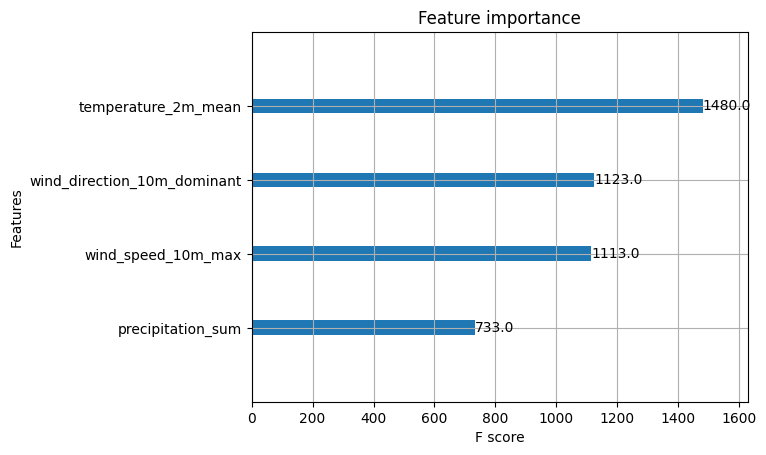

In [32]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)
filename = images_dir + "/feature_importance.png"
plt.savefig(filename)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

### <span style="color:#ff5f27;">⚙️ Model Schema</span>

The model needs to be set up with a [Model Schema](https://docs.hopsworks.ai/machine-learning-api/latest/generated/model_schema/), which describes the inputs and outputs for a model.

A Model Schema can be automatically generated from training examples, as shown below.

In [33]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [34]:
# Saving the label encoder and XGBoost regressor as joblib files in the model directory
# joblib.dump(xgb_regressor, model_dir + '/xgboost_regressor.pkl')
xgb_regressor.save_model(model_dir + "/model.json")

In [35]:
res_dict = { 
        "RMSE": str(rmse),
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [36]:

mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://snurran.hops.works/p/5240/models/air_quality_xgboost_model/5


Model(name: 'air_quality_xgboost_model', version: 5)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
